# COURSE: PCA and multivariate neural signal processing
## SECTION: Source separation with GED
### VIDEO: Spectral scanning in EEG data
#### Instructor: sincxpress.com

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io as sio
from pytopo import topoplotIndie
from filterFGxfun import filterFGx

# For more about this method, see:
# de Cheveigne and Arzounian (2015) Journal of Neural Engineering

In [10]:
matfile = sio.loadmat('MATLAB_data_files/CEdata.mat')
EEG = matfile['EEG'][0,0]
EEG['times'] = EEG['times'][0]
EEG['data'] = np.double(EEG['data']) ## higher accuracy with double-precision data

In [15]:
# parameters and initializations

# specify frequencies in Hz
minFreq =  2
maxFreq = 30
numFreq = 35

frex = np.linspace(minFreq,maxFreq,numFreq)

# initialize
eigsAll = np.zeros(numFreq)
maps    = np.zeros((numFreq,EEG['nbchan'][0][0]))
print(EEG['data'].shape)

(64, 2048, 250)


In [18]:
## find narrowband components

# compute R matrix (not inside frequency loop!)
tmpdata = np.reshape(EEG['data'],(EEG['nbchan'][0][0],-1),order='F')
bcov = np.cov(tmpdata)

for fi in range(numFreq):
    
    # narrowband filter the data
    fdat = copy.deepcopy(EEG['data'])
    for ti in range(int(EEG['trials'])):
        tmdat = EEG['data'][:,:,ti]
        fdat[:,:,ti] = filterFGx(tmdat,EEG['srate'][0][0],frex[fi],5)[0]
    
    # compute S matrix
    #print(fdat.shape)
    fdat = np.reshape(fdat,(EEG['nbchan'][0][0],-1),order='F')
    fcov = np.cov(fdat)
    #print(fdat.shape)

In [19]:
    # GED
    evals,evecs = scipy.linalg.eigh(fcov,bcov)
    sidx  = np.argsort(evals)[::-1]
    evals = evals[sidx]
    evecs = evecs[:,sidx]
    
    # save eigenvalues
    eigsAll[fi] = evals[0]
    
    # fix sign and store maps
    tmap       = evecs[:,0].T @ fcov
    maxe       = np.argmax(np.abs(tmap))
    maps[fi,:] = tmap * np.sign(tmap[maxe])

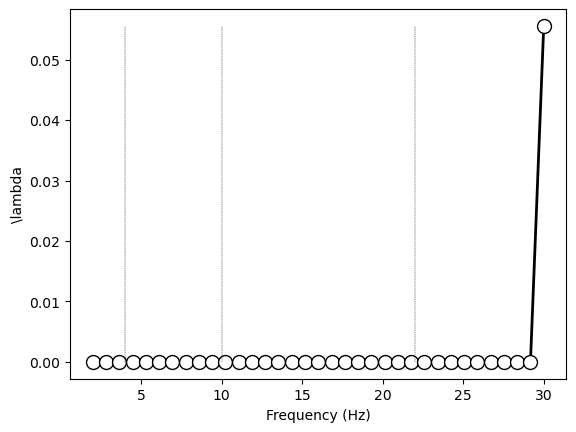

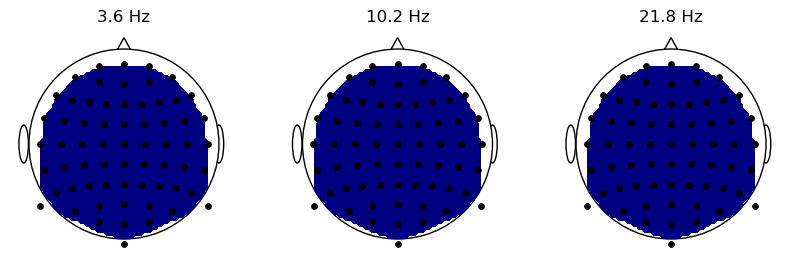

In [20]:
## plot

# frequencies (in Hz) for topographical inspection
# note: code is currently hard-coded to three frequencies!
frex4topos = [ 4, 10, 22 ]

plt.plot(frex,eigsAll,'ko-',markerfacecolor='w',markersize=10,linewidth=2)

# plot lines to indicate frequencies
for f in frex4topos:
    plt.plot([f,f],[0,np.max(eigsAll)],'k--',linewidth=.3)

plt.xlabel('Frequency (Hz)')
plt.ylabel('\lambda')
plt.show()


_,axs = plt.subplots(1,3,figsize=(10,5))
for i in range(3):
    # frequency index
    fidx = np.argmin(np.abs(frex-frex4topos[i]))
    
    # topomap
    topoplotIndie(maps[fidx,:],EEG['chanlocs'],f'{frex[fidx]:.1f} Hz',axs[i])